In [75]:
!git clone https://github.com/jacoponudo/Size_effects.git

Cloning into 'Size_effects'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 0), reused 12 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (16/16), 6.51 KiB | 1.30 MiB/s, done.


In [80]:

root='/kaggle/working/'
import sys
module_path = root+'Size_effects/EXP'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import pandas as pd
from EXP_package.functions import *
!pip install fastparquet
!pip install gdown

# Reddit

In [144]:
# Scarica il dataset di Reddit
import gdown

url='https://drive.google.com/uc?id=1QepHehlhqP-jtOcshFzajqxj1DpJtoj7'
output='reddit.parquet'

gdown.download(url,output,quiet=False)
reddit = pd.read_parquet('/kaggle/working/reddit.parquet')

social=reddit

Downloading...
From (original): https://drive.google.com/uc?id=1QepHehlhqP-jtOcshFzajqxj1DpJtoj7
From (redirected): https://drive.google.com/uc?id=1QepHehlhqP-jtOcshFzajqxj1DpJtoj7&confirm=t&uuid=05125669-5049-4710-bd51-91000bef8dfc
To: /kaggle/working/reddit.parquet
100%|██████████| 334M/334M [00:06<00:00, 47.8MB/s] 


# Gab

In [151]:
# Scarica il dataset di Gab
import gdown

url='https://drive.google.com/uc?id=1CpsRAaBVv4hIoq713KQmWYyZOlMG2BpH'
output='gab.parquet'

gdown.download(url,output,quiet=False)
gab = pd.read_parquet('/kaggle/working/gab.parquet')

social=gab

Downloading...
From (original): https://drive.google.com/uc?id=1CpsRAaBVv4hIoq713KQmWYyZOlMG2BpH
From (redirected): https://drive.google.com/uc?id=1CpsRAaBVv4hIoq713KQmWYyZOlMG2BpH&confirm=t&uuid=cb878886-b69d-4f32-9c1c-f1b3f8def0a8
To: /kaggle/working/gab.parquet
100%|██████████| 1.95G/1.95G [00:11<00:00, 176MB/s] 


NameError: name 'gab' is not defined

In [ ]:
gab = pd.read_parquet('/kaggle/working/gab.parquet')

social=gab

## Facebook

In [83]:
# Scarica i tre dataset che appartengono a Facebook
import gdown
url='https://drive.google.com/uc?id=1Y2lGWkcgo_IWHdWFh_Qcn0K74D_xQhvB'
output='facebook_news.csv'
gdown.download(url,output,quiet=False)

url='https://drive.google.com/uc?id=1KGH2s8sPnvXZc7_wVgTCoGTXPr3B7SCe'
output='facebook_brexit.csv'
gdown.download(url,output,quiet=False)

url='https://drive.google.com/uc?id=17q4X4JHYJBz1jF58XvYfbKqZLy-jtmzM'
output='facebook_vaccines.csv'
gdown.download(url,output,quiet=False)

# Leggi i tre dataset con pandas
facebook_news = pd.read_csv('/kaggle/working/facebook_news.csv', dtype={'from_id': str})
facebook_vaccines_all_comments_scored = pd.read_csv('/kaggle/working/facebook_vaccines.csv', dtype={'from_id': str})
facebook_brexit_all_comments_scored = pd.read_csv('/kaggle/working/facebook_brexit.csv', dtype={'from_id': str})

# Etichetta e raggruppa i tre dataset
facebook_vaccines = facebook_vaccines_all_comments_scored.copy()
facebook_vaccines['topic'] = 'Vaccines'

facebook_brexit= facebook_brexit_all_comments_scored.copy()
facebook_brexit['topic'] = 'Brexit'

facebook_news = facebook_news.copy()
facebook_news['topic'] = 'News'

facebook = pd.concat([facebook_vaccines, facebook_brexit, facebook_news])
facebook.reset_index(drop=True, inplace=True)
facebook['user_id']=facebook['from_id']

social=facebook

# Gini index of Activity

Calcoliamo per ogni thread un coefficiente di Gini che misuri la concentrazione dell'attività degli utenti.

100%|██████████| 26653/26653 [00:15<00:00, 1746.15it/s]


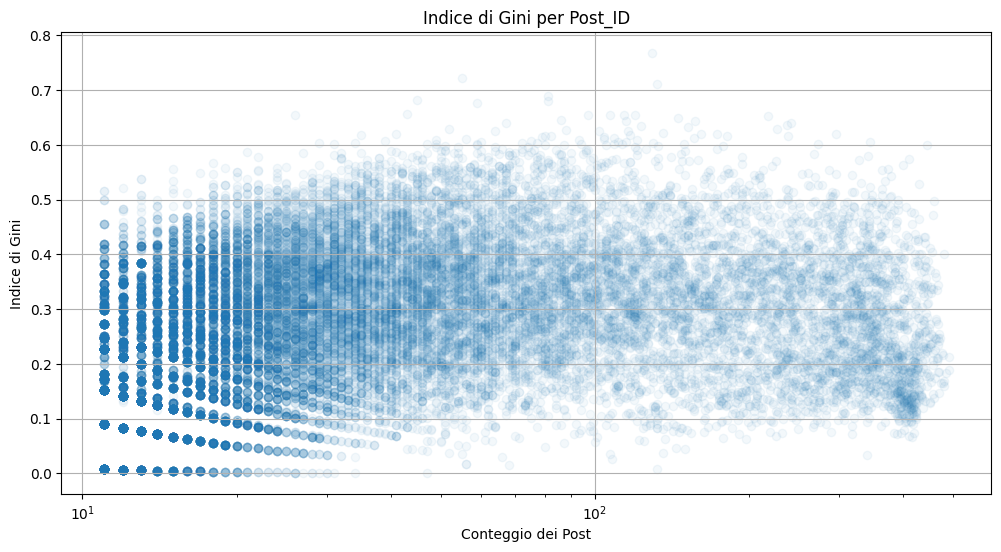

In [152]:
# Conta i commenti per ogni post_id
N_df = social['post_id'].value_counts().reset_index()
N_df.columns = ['post_id', 'count']
N_df=N_df[N_df['count']>10]

# Filtra i post con meno di 
so=social[social['post_id'].isin(N_df['post_id'])]

# Calcola il coefficiente di gini sulla concentrazione dell'attività degli utenti 
gini_df = calculate_gini_for_posts(so)

# Unisci i dati sul post_id
merged_df = pd.merge(gini_df, N_df, on='post_id')

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(merged_df['count'], merged_df['gini_index'], alpha=0.05)
plt.title('Indice di Gini per Post_ID')
plt.xlabel('Conteggio dei Post')
plt.ylabel('Indice di Gini')
plt.xscale('log')  # Log scale for better visualization if the count ranges widely
plt.yscale('linear')  # Adjust scale as needed
plt.grid(True)
plt.show()


Boxplot del coefficiente di gini rispetto al numero di utenti in un thread

<Figure size 1200x600 with 0 Axes>

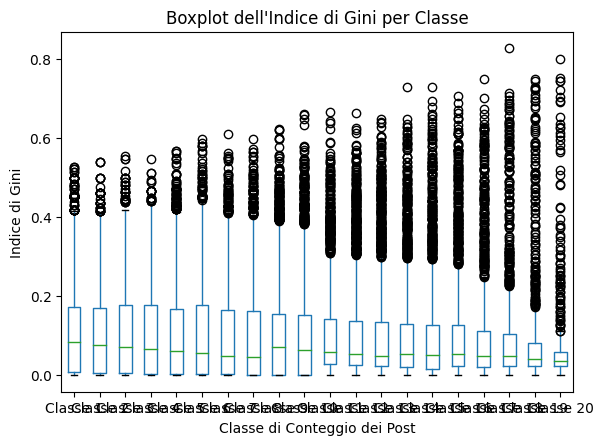

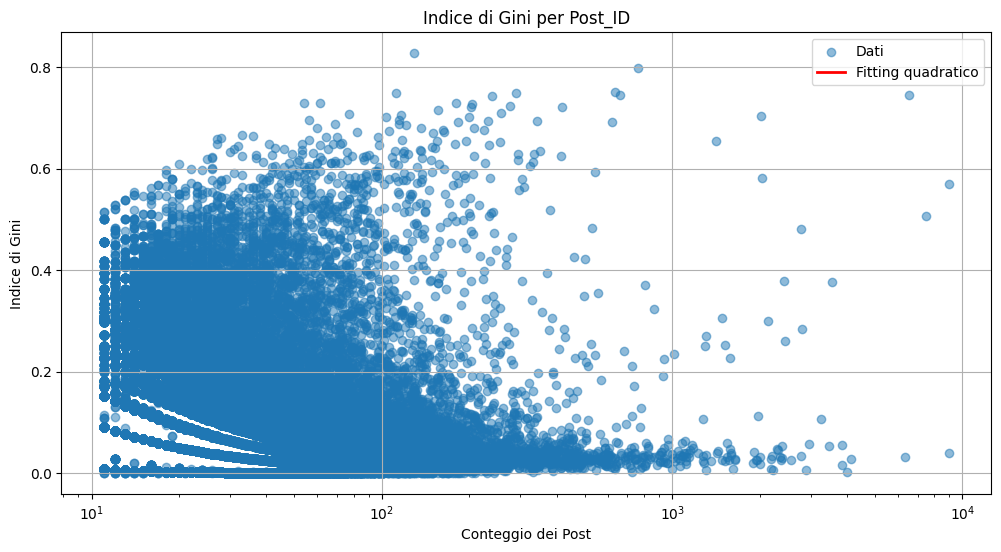

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Supponiamo che merged_df sia già definito e contenga 'count' e 'gini_index'
x = merged_df['count']
y = merged_df['gini_index']

# Creare tre classi omogenee basate sui quantili dei dati
quantiles = np.percentile(x, np.linspace(0, 100, 21))  # 10 classi
labels = [f'Classe {i+1}' for i in range(20)]  # Etichette per le 10 classi
merged_df['classe'] = pd.cut(x, bins=quantiles, labels=labels, include_lowest=True)

# Creare boxplot per le tre classi
plt.figure(figsize=(12, 6))
merged_df.boxplot(column='gini_index', by='classe', grid=False)
plt.title('Boxplot dell\'Indice di Gini per Classe')
plt.suptitle('')  # Rimuovere il titolo generato automaticamente
plt.xlabel('Classe di Conteggio dei Post')
plt.ylabel('Indice di Gini')
plt.show()



## **Funcions** 

In [148]:
import pandas as pd
import numpy as np

def gini_coefficient(values):
    if len(values) == 0:
        return np.nan  # O un valore che hai scelto per i casi senza dati
    sorted_values = np.sort(values)
    cumulative_values = np.cumsum(sorted_values)
    
    # Aggiungi un controllo per evitare problemi con array troppo piccoli
    if len(cumulative_values) == 1:
        return 0  # O un valore che hai scelto per i casi con un solo elemento
    
    lorenz_curve = cumulative_values / cumulative_values[-1]
    gini_index = 1 - 2 * np.trapz(lorenz_curve, dx=1/len(lorenz_curve))
    return gini_index


def calculate_gini_for_posts(df):
    """Calcola l'indice di concentrazione di Gini per ogni post_id basato sul numero di righe per utente."""
    gini_results = []
    
    # Raggruppa i dati per post_id
    grouped = df.groupby('post_id')
    
    for post_id, group in tqdm(grouped):
        # Conta il numero di righe per ogni utente
        user_counts = group['user_id'].value_counts()
        # Calcola l'indice di Gini per questi conteggi
        gini_index = gini_coefficient(user_counts.values)
        gini_results.append({'post_id': post_id, 'gini_index': gini_index})
    
    return pd.DataFrame(gini_results)
